In [ ]:
args = {
    "dataset_folder": "./train_10M",
   
}

: 

In [2]:
import os
import os
os.environ['HF_HOME'] = '/data/loriss21dm/cache'
from datasets import load_dataset
import datasets
import torch
import json

: 

In [3]:
!mkdir curricula

mkdir: cannot create directory ‘curricula’: File exists


### Curriculum 2023 dataset

The exact data from Thoma et al 2023. Note that the model does not see all examples in each epoch.

In [4]:
from datasets import load_dataset
import os
os.environ['HF_HOME'] = '/data/loriss21dm/cache'
# dev = load_dataset("babylm-anon/dev-data")

: 

In [5]:
LAST_GEN_DIR = "last_gen"
EPOCHS_PER_STAGE = 10
datasets_stages = []
orders_stages = []

torch.manual_seed(0)
for folder in (sorted(os.listdir(LAST_GEN_DIR))):
    d = load_dataset("text", data_dir =os.path.join(LAST_GEN_DIR, folder), cache_dir='/data/loriss21dm/cache')["train"] 
    d = d.shuffle() # we shuffle within the stage
    d = datasets.Dataset.from_dict(d[0:len(d)//10]) # TODO
    datasets_stages.append(d)
    offset = orders_stages[-1][-1]+1 if len(orders_stages) else 0
    for _ in range(0,EPOCHS_PER_STAGE):
        orders_stages.append(torch.arange(offset,len(d)+offset))
    


dataset = datasets.concatenate_datasets(datasets_stages)

dataset.save_to_disk("./curricula/datasets/curriculum_100M_2023")
#assert torch.equal(torch.cat([o.flatten() for o in orders_stages]),torch.arange(0,len(dataset)))

torch.save(orders_stages, "./curricula/curriculum_100M_2023")
len(orders_stages)

Saving the dataset (0/1 shards):   0%|          | 0/1058753 [00:00<?, ? examples/s]

40

### Curriculum with 10M 2024 dataset

For training with the strategy in Thoma et al 2023. Note that the model does not see all examples in each epoch.

This config is not designed to extract influence estimates from

In [6]:
args["raw_dataset_folder_babylm"] = "./train_10M"
args["raw_eval_dataset_folder_babylm"] = "./train_100M"
args["dataset_folder"] = "./curricula/datasets/curriculum_10M_2024"
args["curriculum_path"] = "./curricula/curriculum_10M_2024"
args["eval_dataset_folder"] = "./curricula/datasets/curriculum_10M_2024_eval"
args["epochs_per_stage"] = 2

args["curriculum"] = {
    "C1": ["childes.train"],
    "C2": ["open_subtitles.train", "bnc_spoken.train"],
    "C3": ["switchboard.train"],
    "C4": ["gutenberg.train"],
    "C5": [ "simple_wiki.train"]
} # TODO

In [7]:


def add_source(entry, source):
    entry["source"] = source
    return entry
def create_dataset(curriculum, raw_dataset_folder):
    datasets_stages = []
    orders_stages = []
    for _, files in curriculum.items():
        d = datasets.concatenate_datasets(
                [
                    load_dataset("text", data_files =os.path.join(raw_dataset_folder, file))["train"] 
                    .map(lambda entry: add_source(entry, file))
                    for file in files
                ]
            )
        d = d.shuffle() # we shuffle with the stage
        datasets_stages.append(d)
        offset = orders_stages[-1][-1]+1 if len(orders_stages) else 0
        for i in range(0,args["epochs_per_stage"]):
            indices = torch.arange(offset,len(d)+offset) # and then shuffle again (across epochs within stages)
            orders_stages.append(indices[torch.randperm(len(indices))])
    return datasets_stages, orders_stages
        
# pretraining data
torch.manual_seed(0)
datasets_stages, orders_stages = create_dataset(args["curriculum"], args["raw_dataset_folder_babylm"])
dataset = datasets.concatenate_datasets(datasets_stages)
dataset = dataset.shuffle()
dataset.save_to_disk(args["dataset_folder"])
torch.save(orders_stages, args["curriculum_path"])

# eval data is a split of (100M dataset - 10M dataset)
# of size 0.05*len(10M dataset)
torch.manual_seed(0)
eval_datasets_stages, _ = create_dataset(args["curriculum"], args["raw_eval_dataset_folder_babylm"])



# remove all strings that are in the eval dataset 
## basically (100M dataset - 10M dataset) but one source at a time as that is faster
datasets_eval = []
lookup = {d[0]["source"]: d for d in datasets_stages}
# print(lookup)
for e in eval_datasets_stages:
    if e[0]["source"] in lookup.keys():
        l = list(set(e["text"]) - set(lookup[e[0]["source"]]["text"]))
        datasets_eval.append(datasets.Dataset.from_dict({"text": l, "source": [e[0]["source"]]*len(l)}))
    else:
        print("warning: adding all of ",  e[0]["source"] )
        datasets_eval.append(e)
dataset_eval = datasets.concatenate_datasets(datasets_eval)

# do a stratified split, requires casting to class  
dataset_eval = dataset_eval.class_encode_column("source")
dataset_eval = dataset_eval.train_test_split(test_size=int(len(dataset)*0.05), shuffle=True, seed=42, stratify_by_column="source")["test"]
# undo casting
def undo_casting(x):
    x["source"] = dataset_eval.features["source"].int2str(x["source"])
    return x
dataset_eval = dataset_eval.map(undo_casting)
# dataset_eval = dataset_eval.filter(lambda x: x["text"] not in l)
# dataset_eval = dataset_eval.shuffle()
dataset_eval.save_to_disk(args["eval_dataset_folder"])



# assert torch.equal(torch.cat([o.flatten() for o in orders_stages]),torch.arange(0,len(dataset)))



len_full_dataset = len(dataset)
args["epoch_equivalents"] = sum([len(o) for o in orders_stages]) / len_full_dataset
args["epochs"] = len(orders_stages)




with open("./configs/curriculum_10M_2024", 'w') as f:
    json.dump(args, f)
args


Saving the dataset (0/1 shards):   0%|          | 0/1179014 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/6487961 [00:00<?, ? examples/s]

Map:   0%|          | 0/58950 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/58950 [00:00<?, ? examples/s]

{'dataset_folder': './curricula/datasets/curriculum_10M_2024',
 'raw_dataset_folder_babylm': './train_10M',
 'raw_eval_dataset_folder_babylm': './train_100M',
 'curriculum_path': './curricula/curriculum_10M_2024',
 'eval_dataset_folder': './curricula/datasets/curriculum_10M_2024_eval',
 'epochs_per_stage': 2,
 'curriculum': {'C1': ['childes.train'],
  'C2': ['open_subtitles.train', 'bnc_spoken.train'],
  'C3': ['switchboard.train'],
  'C4': ['gutenberg.train'],
  'C5': ['simple_wiki.train']},
 'epoch_equivalents': 2.0,
 'epochs': 10}

### Stratified 10M Curriculum built from 100M 2024 dataset

This creates 5 stages of equal size totaling 10M tokens from the 100M data.

In [ ]:
args["raw_dataset_folder_babylm"] = "./train_100M"
args["raw_eval_dataset_folder_babylm"] = "./train_100M"
args["dataset_folder"] = "./curricula/datasets/curriculum_stratified_10M_2024"
args["curriculum_path"] = "./curricula/curriculum_stratified_10M_2024"
args["eval_dataset_folder"] = "./curricula/datasets/curriculum_stratified_10M_2024_eval"
args["epochs_per_stage"] = 2

args["curriculum"] = {
    "C1": ["childes.train"],
    "C2": ["open_subtitles.train", "bnc_spoken.train"],
    "C3": ["switchboard.train"],
    "C4": ["gutenberg.train"],
    "C5": [ "simple_wiki.train"]
} # TODO

: 

In [ ]:
from nltk.tokenize import RegexpTokenizer

: 

In [ ]:

datasets_stages = []
datasets_stages_eval = []
orders_stages = []

BUDGET_PER_STAGE = 10_000_000 // len(args["curriculum"])

tokenizer = RegexpTokenizer(r'\w+')

def get_train_test_splits_for_stage(d):
    d = d.shuffle()
    word_count = lambda d: len([w for w in tokenizer.tokenize(d) if w.isalnum()])
    words_in_split = 0
    i = 0
    wc = word_count(d[i]["text"])
    while (BUDGET_PER_STAGE >= (words_in_split + wc)) and (i < len(d)):
        words_in_split += wc
        i+=1
        wc = word_count(d[i]["text"])
        
    print(BUDGET_PER_STAGE-words_in_split, "tokens left in budget")
    return d[0:i+1], d[i+1:]  # so that train is of size BUDGET_PER_STAGE, and the rest will be further split when generating the eval dataset later

torch.manual_seed(0)
for _, files in args["curriculum"].items():
    d = datasets.concatenate_datasets(
            [
                load_dataset("text", data_files =os.path.join(args["raw_dataset_folder_babylm"], file))["train"] 
                .map(lambda entry: add_source(entry, file))
                for file in files
            ]
        )

    d, d_eval = get_train_test_splits_for_stage(d)
    datasets_stages.append(d)
    datasets_stages_eval.append(d_eval)
    offset = orders_stages[-1][-1]+1 if len(orders_stages) else 0
    for i in range(0,args["epochs_per_stage"]):
        indices = torch.arange(offset,len(d)+offset) # and then shuffle again (across epochs within stages)
        orders_stages.append(indices[torch.randperm(len(indices))])
    

        
# pretraining data
dataset = datasets.concatenate_datasets(datasets_stages)
dataset = dataset.shuffle()
dataset.save_to_disk(args["dataset_folder"])
torch.save(orders_stages, args["curriculum_path"])


torch.manual_seed(0)

dataset_eval = datasets.concatenate_datasets(datasets_stages_eval)

# do a stratified split, requires casting to class  
dataset_eval = dataset_eval.class_encode_column("source")
dataset_eval = dataset_eval.train_test_split(test_size=int(len(dataset)*0.05), shuffle=True, seed=42, stratify_by_column="source")["test"]
# undo casting
def undo_casting(x):
    x["source"] = dataset_eval.features["source"].int2str(x["source"])
    return x
dataset_eval = dataset_eval.map(undo_casting)

dataset_eval.save_to_disk(args["eval_dataset_folder"])



# assert torch.equal(torch.cat([o.flatten() for o in orders_stages]),torch.arange(0,len(dataset)))



len_full_dataset = len(dataset)
args["epoch_equivalents"] = sum([len(o) for o in orders_stages]) / len_full_dataset
args["epochs"] = len(orders_stages)




with open("./configs/curriculum_stratified_10M_2024", 'w') as f:
    json.dump(args, f)
args


Map:   0%|          | 0/5790000 [00:00<?, ? examples/s]


KeyboardInterrupt



### Random Shuffle

This mimicks the default behaviour of Huggingface's `Trainer`: Randomly shuffle dataset after each epoch.
All data is shown at each epoch.

In [8]:
args = {
    "dataset_folder": "./curricula/datasets/curriculum_10M_2024",# reuse one created above
   
}

In [9]:
args["raw_dataset_folder_babylm"] = "./train_10M"
args["curriculum_path"] = "./curricula/random_10M_2024"
args["eval_dataset_folder"] = "./curricula/datasets/curriculum_10M_2024_eval"
args["epochs"] = 10

In [10]:
from datasets import load_dataset
import datasets
dataset = datasets.load_from_disk(args["dataset_folder"]) # reuse one created above

In [11]:
assert torch.equal(torch.sort(torch.randperm(len(dataset))).values, torch.arange(0,len(dataset)))

In [12]:
args["epochs"] = 10
import torch 
torch.manual_seed(0)
random_order = torch.stack([torch.randperm(len(dataset)) for _ in range(0,args["epochs"])])
torch.save(random_order, "./curricula/random_10M_2024")
with open("./configs/random_10M_2024", 'w') as f:
    json.dump(args, f)
args

{'dataset_folder': './curricula/datasets/curriculum_10M_2024',
 'raw_dataset_folder_babylm': './train_10M',
 'curriculum_path': './curricula/random_10M_2024',
 'eval_dataset_folder': './curricula/datasets/curriculum_10M_2024_eval',
 'epochs': 10}

|     Groups     |Version|Filter|n-shot|Metric|Value |   |Stderr|
|----------------|-------|------|-----:|------|-----:|---|-----:|
|blimp_supplement|N/A    |none  |     0|acc   |0.4401|±  |0.0069|
|blimp_filtered  |N/A    |none  |     0|acc   |0.4579|±  |0.0019|


### Random Shuffle with a proportion of the documents beeing random tokens as a control

In [13]:
args = {
    "dataset_folder": "./curricula/datasets/curriculum_10M_2024_noisy",# reuse one created above
   
}
args["raw_dataset_folder_babylm"] = "./train_10M"
args["curriculum_path"] = "./curricula/random_10M_2024_noisy"
args["eval_dataset_folder"] = "./curricula/datasets/curriculum_10M_2024_eval"
args["epochs"] = 10

args["proportion_noise"] = 0.05


In [14]:
import datasets
dataset = datasets.load_from_disk("./curricula/datasets/curriculum_10M_2024")

In [15]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("FacebookAI/roberta-base", max_len=512)
def replace_with_noise(example):
    tokenized = tokenizer(example["text"], return_special_tokens_mask=True, truncation=True, max_length=512)["input_ids"]
    example["text"] = tokenizer.decode(torch.randint(0, tokenizer.vocab_size, (len(tokenized),)), skip_special_tokens=True)
    example["source"] = "noise"
    return example
replace_with_noise(dataset[1000000])


{'text': ' Towns Shim achieving Rapid Tight scrollIn Meter daNar lenses',
 'source': 'noise'}

In [16]:
import torch 
torch.manual_seed(0)
ind_to_replace_with_noise = torch.randperm(int(len(dataset)*args["proportion_noise"]))
dl = dataset.to_list()
for i in ind_to_replace_with_noise:
    dl[i] = replace_with_noise(dl[i])
from collections import ChainMap


dataset = datasets.Dataset.from_dict({k: [line[k] for line in dl] for k in dl[0]})
dataset = dataset.shuffle()
dataset.save_to_disk(args["dataset_folder"])
random_order = torch.stack([torch.randperm(len(dataset)) for _ in range(0,args["epochs"])])
torch.save(random_order, args["curriculum_path"])
with open("./configs/random_10M_2024_noisy", 'w') as f:
    json.dump(args, f)
args

Saving the dataset (0/1 shards):   0%|          | 0/1179014 [00:00<?, ? examples/s]

{'dataset_folder': './curricula/datasets/curriculum_10M_2024_noisy',
 'raw_dataset_folder_babylm': './train_10M',
 'curriculum_path': './curricula/random_10M_2024_noisy',
 'eval_dataset_folder': './curricula/datasets/curriculum_10M_2024_eval',
 'epochs': 10,
 'proportion_noise': 0.05}

In [17]:
ind_to_replace_with_noise[0]

tensor(20294)

## Test random

In [18]:
args = {
    "dataset_folder": "./curricula/datasets/test",   
}
args["raw_dataset_folder_babylm"] = "./train_10M"
args["curriculum_path"] = "./curricula/test_random_curriculum"
args["eval_dataset_folder"] = "./curricula/datasets/test_eval"
args["epochs"] = 3

In [19]:
import datasets
import torch 
torch.manual_seed(0)
import json
#dataset = load_dataset("text", data_dir ="/data/loriss21dm/babylm/train_test", cache_dir='/data/loriss21dm/cache')["train"] 
dataset = datasets.load_from_disk("./curricula/datasets/curriculum_10M_2024") # reuse one created above
dataset = dataset.shuffle()
dataset = datasets.Dataset.from_dict(dataset[0:len(dataset)//1000]) # TODO
dataset.save_to_disk(args["dataset_folder"])

random_order = torch.stack([torch.randperm(len(dataset)) for _ in range(0,args["epochs"])])
torch.save(random_order, args["curriculum_path"])


dataset = datasets.Dataset.from_dict(dataset[0:len(dataset)//10]) # TODO
dataset.save_to_disk(args["eval_dataset_folder"])

with open("./configs/test", 'w') as f:
    json.dump(args, f)
args

Saving the dataset (0/1 shards):   0%|          | 0/1179 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/117 [00:00<?, ? examples/s]

{'dataset_folder': './curricula/datasets/test',
 'raw_dataset_folder_babylm': './train_10M',
 'curriculum_path': './curricula/test_random_curriculum',
 'eval_dataset_folder': './curricula/datasets/test_eval',
 'epochs': 3}

## New Curriculum based on Influence during learning on randomly shuffled data

{'dataset_folder': './curricula/datasets/curriculum_10M_2024', 'raw_dataset_folder_babylm': './train_10M', 'curriculum_path': './curricula/random_10M_2024', 'eval_dataset_folder': './curricula/datasets/curriculum_10M_2024_eval', 'epochs': 10}


,9212,18424,27636,36848,46060,55272,64484,73696,82908,92120,total,text,source,document_lenght
0,0.000000,0.196915,0.464265,0.168282,0.054872,0.023046,0.051617,0.032035,0.015906,0.008399,1.015337,Now you're putting it on me like I'm gonna aba...,open_subtitles.train,14
1,0.215043,0.052703,0.130161,0.045186,0.015314,0.025799,0.008130,-0.002933,0.086384,0.044641,0.620429,= = = childes/CHILDES_UK/Edinburgh/hakeem0903....,childes.train,8
2,0.130555,0.031752,0.398065,0.113166,0.084688,0.072645,0.047322,0.034912,0.011752,0.005345,0.930202,*CHI:\tI don't wear my sweatshirt.,childes.train,7
3,-0.000313,0.001169,0.000973,0.000264,0.029773,0.007767,0.044175,0.013503,0.004643,0.006240,0.108195,The program caused different reactions from co...,simple_wiki.train,37
4,0.002561,0.122183,0.139494,0.037030,0.055496,0.016643,0.027887,0.010327,0.008796,0.119937,0.540355,,simple_wiki.train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179009,0.011064,-0.028697,-0.005899,-0.017692,-0.005494,-0.000605,-0.001288,-0.000507,-0.000258,-0.000148,-0.049523,,childes.train,1
1179010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002727,-0.001382,-0.000334,-0.004443,"""Here in London. It is a powerful and wealthy ...",gutenberg.train,27
1179011,0.000385,0.001423,0.000343,-0.000568,0.000187,-0.000054,0.000143,0.010581,0.008184,0.010588,0.031212,*MOT:\tDada's waiting for you.,childes.train,6
1179012,-0.001100,0.107309,0.023218,0.009043,-0.000616,0.000789,0.000879,0.000590,0.000725,0.003571,0.144407,*MOT:\there can I fix it?,childes.train,7


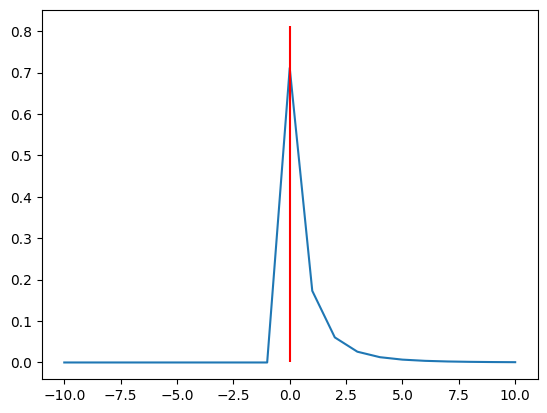

In [20]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import f
from scipy.stats import lognorm


import json
import os
import pandas as pd
import torch
import datasets
from datasets import load_dataset



def gaussian_filter(size, **args):
    indices = np.arange(-size, size+1, 1)
    weights =  norm.pdf(indices, **args)
    return weights# / np.sum(weights)


def f_filter(size, **args):
    indices = np.arange(-size, size+1, 1)
    print(indices)
    weights = f.pdf(indices+1, **args)
    return weights# / np.sum(weights)
def lognorm_filter(size, **args):
    #print(args)
    indices = np.arange(-size, size+1, 1)
    #print(indices)
    weights = lognorm.pdf(indices+1, **args)
    return weights / np.sum(weights)



with open("./configs/random_10M_2024") as f:
    config = json.load(f)
    print(config)
config["influence_output_dir"] = os.path.join("./influence", os.path.basename(config["curriculum_path"]))
dataset = datasets.load_from_disk(config["dataset_folder"])
df = pd.DataFrame({int(result_checkpoint): torch.load(os.path.join(config["influence_output_dir"],result_checkpoint),weights_only=True,map_location="cpu").numpy().flatten() for result_checkpoint in os.listdir(config["influence_output_dir"])})
df.sort_index(axis=1)

df = df.reindex(sorted(df.columns, reverse=False), axis=1)
influence_cols = df.columns
df["total"] = df.sum(axis=1)
df[["text", "source"]] = dataset.to_pandas()
df["document_lenght"] = df["text"].str.split(r"\S+").str.len()




def reweight_df(df, influence_cols, filter_weights):
    scores = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,filter_weights, mode="valid")[1:-1], axis=1, arr=df[influence_cols].to_numpy()))
    scores.columns = influence_cols
    df_reweighted = df.copy()
    df_reweighted[influence_cols] = scores
    df_reweighted["total"] = df_reweighted[influence_cols].sum(axis=1)
    return df_reweighted



filter_weights = lognorm_filter(len(influence_cols), s=1, loc=0, scale=0.5)
plt.plot(np.arange(-len(influence_cols),len(influence_cols)+1, 1),filter_weights)
plt.vlines([0], ymin=0, ymax=max(filter_weights)+0.1, colors=["red"])
df_reweighted = reweight_df(df, influence_cols, lognorm_filter(len(influence_cols), s=1, loc=0, scale=0.5))
display(df_reweighted)




In [21]:
dataset

Dataset({
    features: ['text', 'source'],
    num_rows: 1179014
})

In [22]:
len(packed_dataset[0]["input_ids"])

NameError: name 'packed_dataset' is not defined

In [ ]:
args = {
    "dataset_folder": config["dataset_folder"],   
}
args["raw_dataset_folder_babylm"] = "./train_10M"
args["curriculum_path"] = "./curricula/lognorm_curriculum_from_random_10M_2024"
args["eval_dataset_folder"] = config["eval_dataset_folder"]
args["epochs"] = config["epochs"]

torch.save(torch.stack([torch.tensor(df[checkpoint].sort_values(ascending=False).index.to_numpy()) for checkpoint in influence_cols]), args["curriculum_path"])


with open("./configs/lognorm_curriculum_from_random_10M_2024", 'w') as f:
    json.dump(args, f)